# Outline

- create a model that predicts the category of each article by Neural Network
- use `keras` and `scikeras` (wrapper for scikit-learn) to build a model
- train data is `matichon.json` that contains about 17K articles of Thai news by Matichon between 2015-2018
- X is `article`, using `CountVectorizer` and `TfidfVectorizer`
- unigram and bigram features
- y is category (10 labels)
- F1 score of Logistic Regression using articles with bigram features: **0.81**

# Import

In [13]:
import pandas as pd
import numpy as np
import re, emoji, urllib, html
import matplotlib.pyplot as plt

from keras.layers import Dense, Dropout
from keras.models import Sequential
from scikeras.wrappers import KerasClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from pythainlp.tokenize import word_tokenize

- custom tokenization function
- remove all quotations and shrink newlines `\n` and white spaces 

In [2]:
def my_tokenize(text):
    ### REMOVE URL ###
    text = html.unescape(urllib.parse.unquote(text)) # unescape for unicode, unquote for escaped URL
    text = re.sub(r'https?.+?(?:\s|$)', '', text) # remove URL link
    ### REMOVE EMOJI ###
    text = emoji.replace_emoji(text) # remove emoji
    ### REPLACE ###
    text = re.sub(r'[“”„\"]', '', text) # remove double quotations
    text = re.sub(r'[‘’′′′′`\']', '', text) # remove single quotations
    text = re.sub(r'[\n\t\u00a0\xa0\u3000\u2002-\u200a\u202f]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'เเ', 'แ', text)
    ### SHRINK SOME REDUPLICATION ###
    text = re.sub(r'าา+', 'า', text)
    text = re.sub(r'ยย+', 'ย', text)
    text = re.sub(r'ๆๆ+', 'ๆ', text)
    text = re.sub(r'ะะ+', 'ะ', text)
    ### am ###
    text = re.sub(r'ํา','ำ', text) # o + า -> ำ
    text = re.sub(r'\u0E33([\u0E48\u0E49\u0E4A\u0E4B])', r'\1'+'\u0E33', text) # am + tone -> tone + am
    ### TOKENIZE AND FILTERING ###
    tokens = word_tokenize(text, keep_whitespace=False)
    tokens = [token.strip('(').strip(')') for token in tokens]
    tokens = [token for token in tokens if re.match(r'[A-zก-ไ][A-zก-๙\.]*', token)]
    return ' '.join(tokens) # join with space because CountVectorizer takes sentences as str

# Load data

- target variable is `category`
- `headline` and `article` are untokenized text

In [3]:
df = pd.read_json('data/matichon.json')

## drop "date", "headline", "url", and "id"
df.drop(columns=['date','headline','url','id'], inplace=True)

df

,article,category
0,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,foreign
1,"""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",politics
2,แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,entertainment
3,กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,entertainment
4,แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,entertainment
...,...,...
17104,เมื่อวันที่ 5 ก.ค. ที่ สน.พญาไท น.ส.ณัฏฐา มหัท...,politics
17105,วันที่ 5 กรกฎาคม เจ้าหน้าที่ขุดทางระบายน้ำที่ด...,region
17106,"สนช.ผ่าน พ.ร.บ.สงฆ์ 3 วาระรวด ""วิษณุ"" แจงสาระส...",politics
17107,หมายเหตุ – จากกรณีที่ กระทรวงศึกษาธิการ (ศธ.) ...,education


In [4]:
## value counts of target variable
df.category.value_counts()

politics         3135
region           2655
crime            2141
local            1938
publicize        1481
foreign          1329
economy          1249
sport            1202
education        1053
entertainment     926
Name: category, dtype: int64

# 1. Preprocessing

## tokenize

- input for Vectorizer must be a list of sentences (not list of tokens) 
- it may take more than 1 minute
- you can save the tokenized file by `df.to_json('XXX.json', orient='records', force_ascii=False)`

In [5]:
df['article_tokens'] = df['article'].apply(my_tokenize)
df.head()

,article,category,article_tokens
0,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,foreign,ธ.ค. หนังสือพิมพ์ อัล ริยาด ของ ทางการ ซาอุดีอ...
1,"""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",politics,บิ๊ก ป้อม แจง ครม. มี ความพยายาม ยุยง ปลุกปั่น...
2,แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,entertainment,แม้ จะ ทำหน้าที่ ภรรยา ที่ ดี มา เฝ้า ปอ ทฤษฎี...
3,กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,entertainment,กลายเป็น ดารา หนุ่ม เนื้อ หอม แฟนคลับ แน่น กระ...
4,แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,entertainment,แสดง ดี จน เป็นที่ ถูกอกถูกใจ แฟนคลับ จน ได้รั...


## define `X`, `y` and train-test splitting


In [6]:
X = df['article_tokens']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. Modelling

## define NN model

In [7]:
def create_NN(meta={}):
    ## used in scikeras wrapper
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]

    ## Instantiate Model with 2 hidden layers
    model = Sequential()
    model.add(Dense(n_features_in_, input_shape=X_shape_[1:])) # input layer
    model.add(Dense(128, activation='relu', name=f'Hidden1')) # 1st hidden layer
    model.add(Dropout(0.2, name=f'Dropout1')) 
    model.add(Dense(64, activation='relu', name=f'Hidden2')) # 2nd hidden layer
    model.add(Dropout(0.2, name=f'Dropout2')) 
    model.add(Dense(n_classes_, activation='softmax', name='Output')) # output layer
    return model

## make pipelines

- `Vectorizer` returns sparse matrix but NN accepts only dense matrix
- so, one more transformer is necessary between those two - `FunctionTransformer`

In [8]:
# instantiate vectorizers
# use only 5000 features (if more, it takes too much time)
cvec = CountVectorizer(max_df=0.5, max_features=5000, ngram_range=(1,2))
tvec = TfidfVectorizer(max_df=0.5, max_features=5000, ngram_range=(1,2))

# instantiate NN estimators
NN_cvec = KerasClassifier(create_NN, loss='sparse_categorical_crossentropy', epochs=3, metrics='accuracy', validation_split=0.2)
NN_tvec = KerasClassifier(create_NN, loss='sparse_categorical_crossentropy', epochs=3, metrics='accuracy', validation_split=0.2)

# pipelines
pipe_cvec = Pipeline([('cvec', cvec), ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), ('NN_cvec', NN_cvec)])
pipe_tvec = Pipeline([('tvec', tvec), ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), ('NN_tvec', NN_tvec)])

## fit

- loss is decreasing, but validation loss is increasing gradually = overfitting
- epoch 1-2 may be enough

In [9]:
print("--- Count Vectorizer ---")
pipe_cvec.fit(X_train, y_train)

print("\n--- TFIDF Vectorizer ---")
pipe_tvec.fit(X_train, y_train)

--- Count Vectorizer ---


2023-11-02 18:52:41.850010: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-02 18:52:41.850029: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-02 18:52:41.850037: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-02 18:52:41.850425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-02 18:52:41.850724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/3


2023-11-02 18:52:42.728892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-02 18:52:42.757843: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


343/343 [==============================] - 14s 39ms/step - loss: 1.4507 - accuracy: 0.6215 - val_loss: 1.0776 - val_accuracy: 0.6980
Epoch 2/3
343/343 [==============================] - 13s 37ms/step - loss: 1.0555 - accuracy: 0.7203 - val_loss: 1.2195 - val_accuracy: 0.7290
Epoch 3/3
343/343 [==============================] - 13s 37ms/step - loss: 0.8410 - accuracy: 0.7652 - val_loss: 1.2557 - val_accuracy: 0.7213

--- TFIDF Vectorizer ---
Epoch 1/3
  1/343 [..............................] - ETA: 2:28 - loss: 2.3064 - accuracy: 0.0312

2023-11-02 19:01:54.262518: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


343/343 [==============================] - 13s 37ms/step - loss: 0.8648 - accuracy: 0.7100 - val_loss: 0.6779 - val_accuracy: 0.7710
Epoch 2/3
343/343 [==============================] - 13s 37ms/step - loss: 0.4987 - accuracy: 0.8309 - val_loss: 0.8007 - val_accuracy: 0.7557
Epoch 3/3
343/343 [==============================] - 13s 39ms/step - loss: 0.3422 - accuracy: 0.8816 - val_loss: 0.9124 - val_accuracy: 0.7476


Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.5, max_features=5000,
                                 ngram_range=(1, 2))),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x293872940>)),
                ('NN_tvec',
                 KerasClassifier(epochs=3, loss='sparse_categorical_crossentropy', metrics='accuracy', model=<function create_NN at 0x293872160>, validation_split=0.2))])

## predict and evaluate


In [10]:
pred_cvec = pipe_cvec.predict(X_test)
pred_tvec = pipe_tvec.predict(X_test)

107/107 [==============================] - 0s 4ms/step


### count vectorizer

               precision    recall  f1-score   support

        crime       0.70      0.63      0.66       428
      economy       0.73      0.66      0.70       250
    education       0.70      0.77      0.73       211
entertainment       0.90      0.89      0.89       185
      foreign       0.94      0.86      0.90       266
        local       0.67      0.17      0.27       388
     politics       0.87      0.80      0.84       627
    publicize       0.67      0.85      0.75       296
       region       0.51      0.85      0.64       531
        sport       0.98      0.93      0.95       240

     accuracy                           0.73      3422
    macro avg       0.77      0.74      0.73      3422
 weighted avg       0.75      0.73      0.71      3422



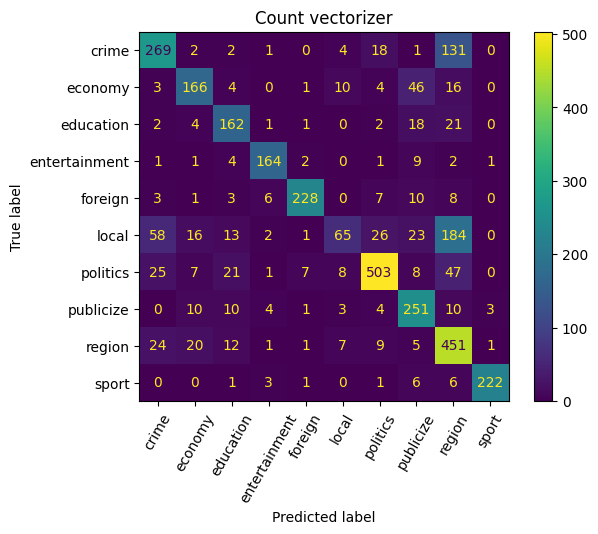

In [16]:
## print F1 scores
print(classification_report(y_test, pred_cvec))

## confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_cvec), display_labels=pipe_cvec.classes_)
disp.plot(xticks_rotation=60)
plt.title('Count vectorizer');

### TFIDF vectorizer

               precision    recall  f1-score   support

        crime       0.72      0.67      0.69       428
      economy       0.73      0.80      0.77       250
    education       0.77      0.80      0.79       211
entertainment       0.82      0.93      0.87       185
      foreign       0.87      0.94      0.90       266
        local       0.44      0.40      0.42       388
     politics       0.83      0.89      0.86       627
    publicize       0.85      0.75      0.79       296
       region       0.70      0.65      0.67       531
        sport       0.95      0.96      0.95       240

     accuracy                           0.76      3422
    macro avg       0.77      0.78      0.77      3422
 weighted avg       0.75      0.76      0.75      3422



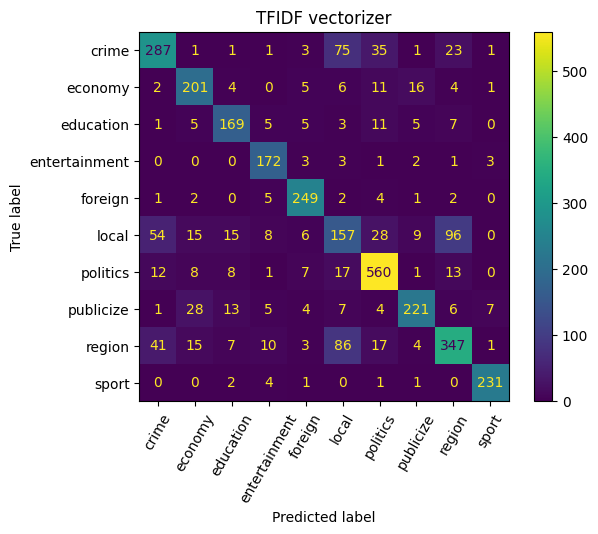

In [14]:
## print F1 scores
print(classification_report(y_test, pred_tvec))

## confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_tvec), display_labels=pipe_tvec.classes_)
disp.plot(xticks_rotation=60)
plt.title('TFIDF vectorizer');

### model comparison

![cm_count_tfidf](image/cm_count_tfidf.png)

# Result Summary


- the accuracy and F1 are lower than Part.1
- must tune hyperparameters (e.g. max features, number of hidden layers), but time-spending
- TFIDF is better a little between the two vectorizers, but confusion matrix shows a different pattern of misprediction